In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os
import time
timestr = '20201021'
    

### Building matrix for logistic regression

In [3]:
#fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_vectorzLR.pkl'
fname = '/tmp/'+timestr+'_hots_vectorzLR_2'

if not os.path.isfile(fname + '_X.npy'):
    
    import pickle
    from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
    from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
    from HOTS.STS import STS
    from HOTS.Layer import ClusteringLayer
    from HOTS.ToolsMonitor import (
        DisplayImage,
        DisplaySurface3D,
        DisplaySurface2D,
        DisplayConvergence,
    )
    from HOTS.Tools import SaveObject, LoadObject
    from HOTS.Network import Network
    from HOTS.Event import conv2eve

    tau = 9e-4 # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
    R = 2
    filthr = 2
    nbkNN = 3
    algo = 'lagorce'
    decay = 'exponential'
    hom = True
    krnlinit = 'rdn'
    nb_cluster = [4, 8, 16]
    ImageSize = (34, 34)
    DataPath = 'Data/testsetnmnist.p'

    NbClusteringData = 15
    NbTrainingData = 40
    NbTestingData = 40
    
    NbClusteringData = 1500
    NbTrainingData = 500
    NbTestingData = 250

    #timestr = time.strftime("%Y%m%d")
    hom = False

    if hom==True:
        fname_model = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname_model = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
    print(fname_model)

    _1ofich = True
    event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
    NbTrainingData, NbTestingData, NbClusteringData, OneOfEach=_1ofich, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

    L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
    L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
    L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
    Net = Network([L1, L2, L3])    
    
    if not os.path.isfile(fname_model):
        ClusterLayer, event_output = Net.TrainCluster(
                event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
            )
        SaveObject(ClusterLayer, fname_model)
    else: 
        ClusterLayer, Classif0 = LoadObject(fname_model)

    fname_event0_o = '/tmp/'+timestr+'_hots_event0_o.p'
    if not os.path.isfile(fname_event0_o):            
        print('run the events through the network')
        homrun = False
        event0_o_tr2 = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        #event0_o_te2 = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
        SaveObject(event0_o_tr2, fname_event0_o)
    
    else: 
        event0_o_tr2 = LoadObject(fname_event0_o)
    
    # gather data
    n_events = event0_o_tr2.time.shape[0]
    tau_cla = .300 # characteristic time of a digit 
    sample_events = 200
    sample_space = 1
    
    data = np.zeros((ImageSize[0]//sample_space, ImageSize[1]//sample_space, len(event0_o_tr2.ListPolarities))) #tmp data
    data_len = len(data.ravel()) # ImageSize[0]//sample_space*ImageSize[1]//sample_space*len(event0_o_tr2.ListPolarities)
    X = np.zeros((n_events//sample_events, data_len))
    y = np.zeros((n_events//sample_events,))
    
    t_absolute = 0
    t_old = 0
    i_label_tr = 0
    for i in range(1, n_events-1):
        if i == event0_o_tr2.ChangeIdx[i_label_tr]:
            i_label_tr += 1
            t_absolute += event0_o_tr2.time[i]
            
        t_new = t_absolute + event0_o_tr2.time[i]
        data *= np.exp(-(t_new-t_old)/tau_cla)
        t_old = t_new
        
        data[event0_o_tr2.address[i, 0]//sample_space, 
             event0_o_tr2.address[i,1]//sample_space, 
             event0_o_tr2.polarity[i]] = 1.

        if i % sample_events == 0:
            print(f'{i=}')
            X[i//sample_events, :] = data.ravel()
            y[i//sample_events] = label_tr[i_label_tr]

    print('Number of events: '+str(X.shape[0])+' - Number of features: '+str(X.shape[1]))
    #SaveObject([X,y], fname)
    np.save(fname + '_X.npy', X)
    np.save(fname + '_y.npy', y)
    
else: 
    #X,y = LoadObject(fname)
    X = np.load(fname + '_X.npy')
    y = np.load(fname + '_y.npy')
    

Records/EXP_03_NMNIST/20201021_hots_0.9ms_lagorce.pkl
[1, 7, 5, 8, 6, 2, 9, 4, 3, 0]
run the events through the network
i=200
i=400
i=600
i=800
i=1000
i=1200
i=1400
i=1600
i=1800
i=2000
i=2200
i=2400
i=2600
i=2800
i=3000
i=3200
i=3400
i=3600
i=3800
i=4000
i=4200
i=4400
i=4600
i=4800
i=5000
i=5200
i=5400
i=5600
i=5800
i=6000
i=6200
i=6400
i=6600
i=6800
i=7000
i=7200
i=7400
i=7600
i=7800
i=8000
i=8200
i=8400
i=8600
i=8800
i=9000
i=9200
i=9400
i=9600
i=9800
i=10000
i=10200
i=10400
i=10600
i=10800
i=11000
i=11200
i=11400
i=11600
i=11800
i=12000
i=12200
i=12400
i=12600
i=12800
i=13000
i=13200
i=13400
i=13600
i=13800
i=14000
i=14200
i=14400
i=14600
i=14800
i=15000
i=15200
i=15400
i=15600
i=15800
i=16000
i=16200
i=16400
i=16600
i=16800
i=17000
i=17200
i=17400
i=17600
i=17800
i=18000
i=18200
i=18400
i=18600
i=18800
i=19000
i=19200
i=19400
i=19600
i=19800
i=20000
i=20200
i=20400
i=20600
i=20800
i=21000
i=21200
i=21400
i=21600
i=21800
i=22000
i=22200
i=22400
i=22600
i=22800
i=23000
i=23200
i=234

IndexError: index 177 is out of bounds for axis 0 with size 177

In [5]:
n_events, i//sample_events

(35549, 177)

In [6]:
print('Number of events: '+str(X.shape[0])+' - Number of features: '+str(X.shape[1]))
#SaveObject([X,y], fname)
np.save(fname + '_X.npy', X)
np.save(fname + '_y.npy', y)

Number of events: 177 - Number of features: 18496


In [7]:
X.shape

(177, 18496)

### Performing logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(random_state=0).fit(X, y)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
lr.score(X, y)

1.0

In [10]:
P_pred = lr.predict_proba(X)
P_pred.shape

(177, 10)

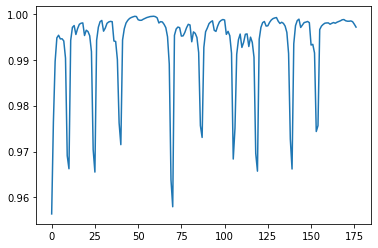

In [11]:
plt.plot(np.max(P_pred, axis=1))